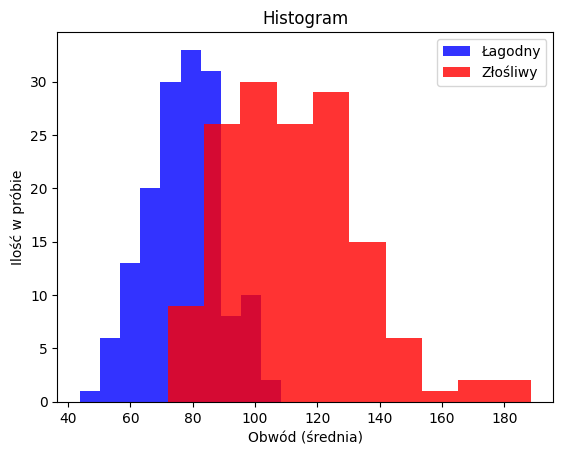

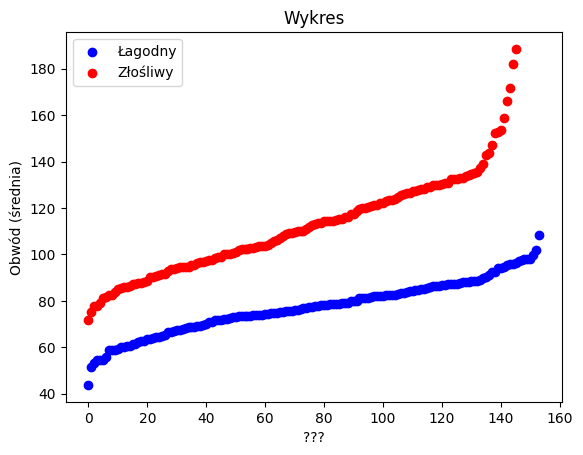

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data
header = pd.io.parsers.read_csv("dataset/breast-cancer.labels", header=None)
data_validate : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", header=None)
data_train : pd.DataFrame = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", header=None)

# Add headers for columns
data_validate.columns = header[0]
data_train.columns = header[0]

# Create histogram
plt.hist(data_train[data_train["Malignant/Benign"] == 'B']["perimeter (mean)"], color="blue", alpha=0.8)
plt.hist(data_train[data_train["Malignant/Benign"] == 'M']["perimeter (mean)"], color="red", alpha=0.8)

plt.legend(["Łagodny", "Złośliwy"])
plt.title("Histogram")
plt.xlabel("Obwód (średnia)")
plt.ylabel("Ilość w próbie")
plt.show()

#Create chart
chart_malignant = data_train[data_train["Malignant/Benign"] == 'M']["perimeter (mean)"].to_list()
chart_malignant.sort()

chart_benign = data_train[data_train["Malignant/Benign"] == 'B']["perimeter (mean)"].to_list()
chart_benign.sort()


plt.scatter([i for i in range(len(chart_benign))], chart_benign, color="blue")
plt.scatter([i for i in range(len(chart_malignant))], chart_malignant, color="red")
plt.legend(["Łagodny", "Złośliwy"])
plt.title("Wykres")
plt.xlabel("???")
plt.ylabel("Obwód (średnia)")
plt.show()



## Metoda najmniejszych kwadratów

### Budowa macierzy A

In [60]:
# A matrices for our datasets

# Linear representation

temp = data_train.drop(labels=["patient ID", "Malignant/Benign"], axis="columns")
A_linear_train = temp.to_numpy()

temp = data_validate.drop(labels=["patient ID", "Malignant/Benign"], axis="columns")
A_linear_validate = temp.to_numpy()


# Quadratic representation

def create_quad_rep_matrix(temp : np.ndarray):
    # f_x - multiplying x term by all that appear later
    f_1 = temp[:, 0][:, np.newaxis] * temp[:, 1:]
    f_2 = temp[:, 1][:, np.newaxis] * temp[:, 2:]
    f_3 = temp[:, 2][:, np.newaxis] * temp[:, 3:]

    # Put together all the terms
    return np.hstack((temp, temp**2, f_1, f_2, f_3))


data_train[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].to_numpy()

A_quadratic_train = create_quad_rep_matrix(data_train[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].to_numpy())

A_quadratic_validate = create_quad_rep_matrix(data_validate[["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]].to_numpy())


### Small example to help imagine the transformation

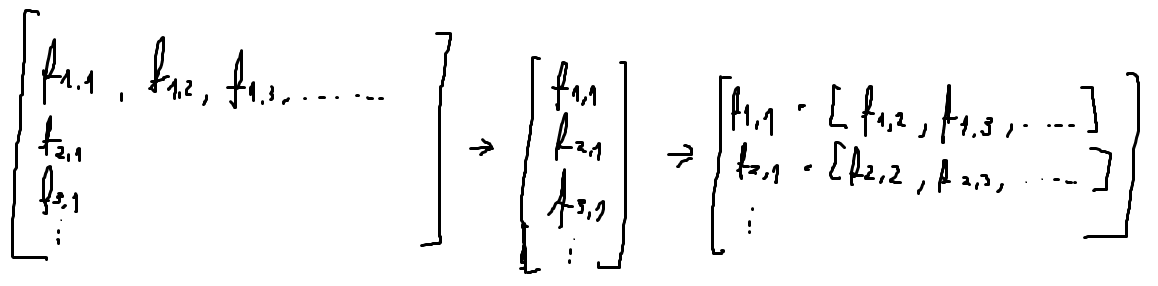


### Budowa wektorów B

In [66]:
B_train = np.where(data_train["Malignant/Benign"] == "M", 1, -1)

B_validate = np.where(data_validate["Malignant/Benign"] == "M", 1, -1)

### Obliczenie wektorów wag przy pomocy równania normalnego

In [ ]:
# Transposed A matrix


AT_lin = np.transpose(A_linear_train)

# Calculate weight vector for linear representation
w_linear = np.linalg.solve(np.matmul(AT_lin, A_linear_train), np.matmul(AT_lin, B_train))


# Transposed A matrix
AT_quad = np.transpose(A_quadratic_train)

# Calculate weight vector for quadratic representation
w_quad = np.linalg.solve(np.matmul(AT_quad, A_quadratic_train), np.matmul(AT_quad, B_train))

import scipy.linalg
w_linear_scipy = scipy.linalg.lstsq(np.matmul(AT_lin, A_linear_train), np.matmul(AT_lin, B_train))


print("Comparing weights vectors calculated from normal equation and with SVD method:\n")
print(w_linear)
print("========================================================================")
print(w_linear_scipy[0])


Comparing weights vectors calculated from normal equation and with SVD method
[-8.69922200e-01  2.43139450e-02  6.26796038e-02  3.27462015e-03
  8.79030463e+00 -1.74714768e+00  2.02847615e-01  6.50644947e+00
 -5.06176015e+00 -4.91675449e+01  9.56592244e-01  8.20527005e-02
  7.94307879e-03 -4.97690954e-03  2.78419378e+01 -3.30151884e+00
 -4.98595672e+00  1.63188873e+01 -1.03162901e+01  2.13321684e+01
  4.08605799e-01  3.34571693e-03  6.77876803e-04 -2.51073512e-03
 -4.53136916e+00 -5.90110921e-01  7.19368538e-01  2.15896728e+00
  3.80346694e+00  1.22984246e+01]
[-8.69922201e-01  2.43139450e-02  6.26796039e-02  3.27462016e-03
  8.79030464e+00 -1.74714768e+00  2.02847615e-01  6.50644947e+00
 -5.06176015e+00 -4.91675449e+01  9.56592244e-01  8.20527006e-02
  7.94307877e-03 -4.97690954e-03  2.78419378e+01 -3.30151883e+00
 -4.98595672e+00  1.63188873e+01 -1.03162901e+01  2.13321684e+01
  4.08605799e-01  3.34571692e-03  6.77876796e-04 -2.51073512e-03
 -4.53136916e+00 -5.90110921e-01  7.1936853

### Współczynniki uwarunkowania $cond(A^T A)$

In [75]:
print(f"Współczynnik uwarunkowania dla reprezentacji liniowej: {np.linalg.cond(A_linear_train)**2}")
print(f"Współczynnik uwarunkowania dla reprezentacji kwadratowej: {np.linalg.cond(A_quadratic_train)**2}")

Współczynnik uwarunkowania dla reprezentacji liniowej: 1809248222517.8499
Współczynnik uwarunkowania dla reprezentacji kwadratowej: 9.056816679083884e+17


## Przewidywania typów nowotworów


In [92]:
p_lin = np.matmul(A_linear_validate, w_linear)

p_quad = np.matmul(A_quadratic_validate, w_quad)

tp = 0
tn = 0
fp = 0
fn = 0

# przewidywanie typu złośliwego
for i in range(len(p_lin)):
    # ture positive
    if p_lin[i] > 0:
        if data_validate["Malignant/Benign"][i] == 'M':
            tp += 1
        else:
            fp += 1
    else:
        if data_validate["Malignant/Benign"][i] == 'B':
            tn += 1
        else:
            fn += 1

print(f"Accuracy: {round((tp+tn)/(len(p_lin)) * 100, 3)}%\n")

print("Confusion matrix:")
display(pd.DataFrame([[tp, fp], [fn, tn]], ["Predicted positive", "Predicted negative"], ["Actually positive", "Actually negative"]))



Accuracy: 96.923%

Confusion matrix:


,Actually positive,Actually negative
Predicted positive,58,6
Predicted negative,2,194
